In [9]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
from scipy.stats import norm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from models.VAE import VAE
from utils.loaders import load_mnist, load_model

In [10]:
# run params
SECTION = 'vae'
RUN_ID = '0003'
DATA_NAME = 'digits'
RUN_FOLDER = Path(f'run/{SECTION}')
RUN_FOLDER = RUN_FOLDER / Path('_'.join([RUN_ID, DATA_NAME]))
MODE =  'build' #'load' #

if not RUN_FOLDER.exists():
    RUN_FOLDER.mkdir(parents=True, exist_ok=True)
    for ext in [Path('viz'), Path('images'), Path('weights')]:
        (RUN_FOLDER / ext).mkdir(parents=True, exist_ok=False)

In [12]:
(x_train, y_train), (x_test, y_test) = load_mnist()
x_train.shape

(60000, 28, 28, 1)

In [13]:
vae = VAE(
    input_dim = (28,28,1),
    encoder_conv_filters = [32,64,64,64],
    encoder_conv_kernel_size = [3,3,3,3],
    encoder_conv_strides = [1,2,2,1],
    decoder_conv_t_filters = [64,64,32,1],
    decoder_conv_t_kernel_size = [3,3,3,3],
    decoder_conv_t_strides = [1,2,2,1],
    z_dim = 2,
)

if MODE == 'build':
    vae.save(RUN_FOLDER)
else:
    vae.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))

In [14]:
LEARNING_RATE = 0.0005
R_LOSS_FACTOR = 1000
BATCH_SIZE = 32
EPOCHS = 50
PRINT_EVERY_N_BATCHES = 100
INITIAL_EPOCH = 0

In [16]:
optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE)
vae.compile(
    optimizer=optimizer,
    reconstruction_weight=R_LOSS_FACTOR,
    learning_rate=LEARNING_RATE
)

vae.fit(
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    run_folder = RUN_FOLDER,
    print_every_n_batches = PRINT_EVERY_N_BATCHES,
    initial_epoch = 0,
    lr_decay = 1,
)

Epoch 1/50
1243/1875 [==================>...........] - ETA: 1:23 - loss: 75.8913 - reconstruction_loss: 57.7812 - kl_loss: 3.0899

KeyboardInterrupt: 

In [42]:
vae = load_model(VAE, RUN_FOLDER)

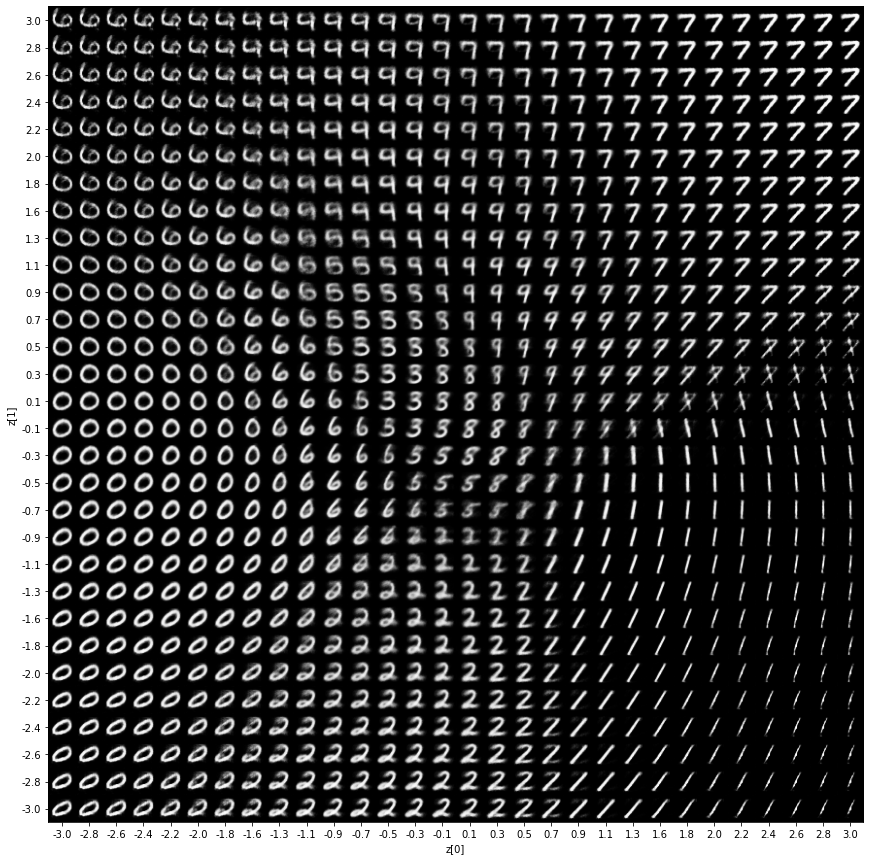

In [43]:
def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 3.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

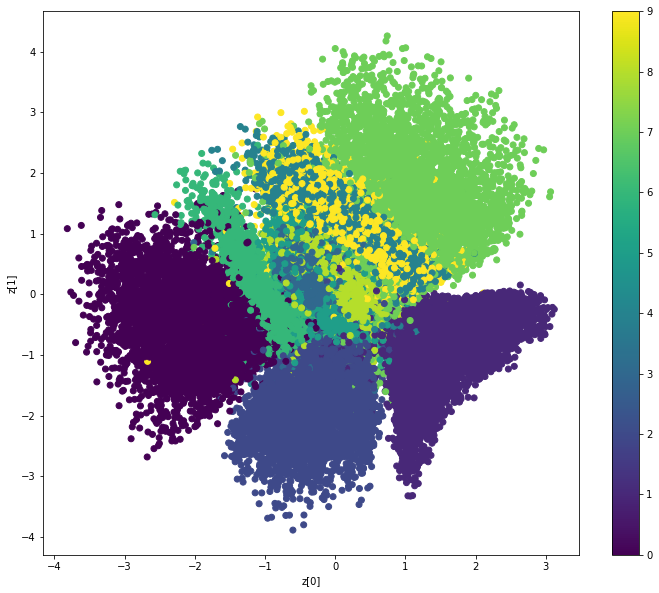

In [44]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)


In [9]:
n_to_show = 10
example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]

z_points = vae.encoder.predict(example_images)
reconst_images = vae.decoder.predict(z_points)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+1)
    sub.axis('off')
    sub.text(0.5, -0.35, str(np.round(z_points[i],1)), fontsize=10, ha='center', transform=sub.transAxes)
            
    sub.imshow(img, cmap='gray_r')

for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    sub.axis('off')
    sub.imshow(img, cmap='gray_r')

ValueError: in user code:

    /Users/fred.shone/.ve/caveat/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1478 predict_function  *
        return step_function(self, iterator)
    /Users/fred.shone/.ve/caveat/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/fred.shone/.ve/caveat/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/fred.shone/.ve/caveat/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/fred.shone/.ve/caveat/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/fred.shone/.ve/caveat/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1461 run_step  **
        outputs = model.predict_step(data)
    /Users/fred.shone/.ve/caveat/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1434 predict_step
        return self(x, training=False)
    /Users/fred.shone/.ve/caveat/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /Users/fred.shone/.ve/caveat/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:207 assert_input_compatibility
        ' input tensors. Inputs received: ' + str(inputs))

    ValueError: Layer decoder expects 1 input(s), but it received 3 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 2) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 2) dtype=float32>, <tf.Tensor 'IteratorGetNext:2' shape=(None, 2) dtype=float32>]


In [ ]:
n_to_show = 5000
figsize = 12

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = vae.encoder.predict(example_images)

min_x = min(z_points[:, 0])
max_x = max(z_points[:, 0])
min_y = min(z_points[:, 1])
max_y = max(z_points[:, 1])

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1], c='black', alpha=0.5, s=2)
plt.show()

In [ ]:
n_to_show = 5000
grid_size = 15
fig_height = 7
fig_width = 15

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = vae.encoder.predict(example_images)
p_points = norm.cdf(z_points)

fig = plt.figure(figsize=(fig_width, fig_height))

ax = fig.add_subplot(1, 2, 1)
plot_1 = ax.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=2)
plt.colorbar(plot_1)

ax = fig.add_subplot(1, 2, 2)
plot_2 = ax.scatter(p_points[:, 0] , p_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=5)



plt.show()

In [ ]:
n_to_show = 5000
grid_size = 20
figsize = 8

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = vae.encoder.predict(example_images)

plt.figure(figsize=(5, 5))
plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=2)
plt.colorbar()

x = norm.ppf(np.linspace(0.01, 0.99, grid_size))
y = norm.ppf(np.linspace(0.01, 0.99, grid_size))
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
z_grid = np.array(list(zip(xv, yv)))

reconst = vae.decoder.predict(z_grid)

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'black'#, cmap='rainbow' , c= example_labels
            , alpha=1, s=2)




plt.show()


fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i+1)
    ax.axis('off')
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')